Generated partially with ChatGPT (chat.openai.com).


In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [3]:
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# Define the dataset
class MoGData(object):
  def __init__(self, dimension=2, num_classes=2):
    # Define the parameters for the two Gaussian distributions
    self.dimension = dimension
    self.num_classes = num_classes
    
    self.mu = np.zeros((num_classes, dimension))
    self.sigma = np.zeros((num_classes, dimension, dimension))
    self.distrib = []

    for i in range(num_classes):
      for j in range(dimension):
        self.mu[i, j] = np.random.uniform(-10, 10)
      self.sigma[i] = np.eye(dimension)  # Identity matrix for variance
      self.distrib.append(multivariate_normal(mean=self.mu[i], cov=self.sigma[i]))
      print(self.sigma[i])

  def sample_data(self, num_samples = 10000):
    # Generate samples from the two Gaussian distributions
    samples = []
    for i in range(self.num_classes):
      samples.append(np.random.multivariate_normal(self.mu[i], self.sigma[i], num_samples))
    # samples0 = np.random.multivariate_normal(self.mu0, self.sigma0, num_samples)
    # samples1 = np.random.multivariate_normal(self.mu1, self.sigma1, num_samples)

    # Combine the samples and create labels
    data = np.concatenate(samples).astype(np.float32)
    labels = np.concatenate([[i]*num_samples for i in range(self.num_classes)]).astype(int)

    # Shuffle the data and labels together
    combined = list(zip(data, labels))
    # random.shuffle(combined)
    data[:], labels[:] = zip(*combined)
    return data, labels
  
  def plot(self, num_samples):
    data, labels = self.sample_data(num_samples)
    print(data.shape)
    print(labels.shape)
    fig = plt.figure()
    
    if self.dimension !=2 and self.dimension !=3:
      return
    
    if self.dimension == 3:
      ax = fig.add_subplot(111, projection='3d')
      for i in range(self.num_classes):
        samples = data[labels==i]
        # random color
        color = np.random.rand(3)
        ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c=[color], label='class '+str(i), alpha=0.05)
      plt.legend()
      plt.show()

    elif self.dimension == 2:
      for i in range(self.num_classes):
        samples = data[labels==i]
        # random color
        color = np.random.rand(3)
        plt.scatter(samples[:, 0], samples[:, 1], c=color, label='class '+str(i), alpha=0.05)
      plt.legend()
      plt.show()

  # def compute_likelihood_ratio(self, labels, data_points):
  #   print(data_points.shape)
  #   """p(y=0|x), assuming p(y=0)=p(y=1)=0.5"""
  #   gt_probs = np.zeros(data_points.shape[0])

  #   for i in range(data_points.shape[0]):
  #     distance = np.zeros(self.num_classes)
  #     for j in range(self.num_classes):
  #       distance[j] = self.distrib[j].pdf(data_points[i])
  #     gt_probs[i] = distance[labels[i]] / distance.sum()
  #   return gt_probs

  def compute_likelihood_ratio(self, labels, data_points):
    """p(y=0|x), assuming p(y=0)=p(y=1)=0.5"""
    # 计算所有数据点在每个类别分布下的pdf值
    distances = np.array([self.distrib[j].pdf(data_points) for j in range(self.num_classes)]).T
    
    # 获取每个数据点对应类别的pdf值
    gt_probs = distances[np.arange(data_points.shape[0]), labels] / distances.sum(axis=1)
    
    return gt_probs

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(30000, 3)
(30000,)


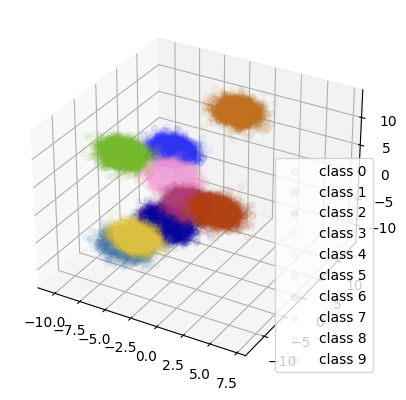

In [7]:
# Dataset Initialization

num_samples = 100000
batch_size = 1000
dimension = 3
num_classes = 10

mog_data = MoGData(dimension=dimension, num_classes=num_classes)
mog_data.plot(num_samples=3000)
train_loader = DataLoader(CustomDataset(*mog_data.sample_data(num_samples=num_samples)),
                          batch_size=batch_size,
                          shuffle=True)

In [4]:
# Define the DNN model
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# class DNN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(DNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.bn1 = nn.BatchNorm1d(hidden_size)
#         self.relu1 = nn.ReLU()
        
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.bn2 = nn.BatchNorm1d(hidden_size)
#         self.relu2 = nn.ReLU()
        
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.bn3 = nn.BatchNorm1d(hidden_size)
#         self.relu3 = nn.ReLU()
        
#         self.fc4 = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.bn1(out)
#         out = self.relu1(out)
        
#         out = self.fc2(out)
#         out = self.bn2(out)
#         out = self.relu2(out)
        
#         out = self.fc3(out)
#         out = self.bn3(out)
#         out = self.relu3(out)
        
#         out = self.fc4(out)
#         return out

In [5]:
# Define custom loss functions
class CrossEntropy(nn.Module):
    def __init__(self):
        super(CrossEntropy, self).__init__()

    def forward(self, input, target):

        target = target.view(-1, 1)
        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        loss = -1 * logpt

        return loss.mean()

class CrossEntropyProb(nn.Module):
    def __init__(self, gamma=2):
        super(CrossEntropyProb, self).__init__()
        self.gamma = gamma
    def forward(self, input, target, gt_prob):

        target = target.view(-1,1)
        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)

        pt = logpt.exp()

        # Get the correct class probability
        # Eg if target is 0, gt_prob is prob(0) = |0 - prob(0)|
        # If target is 1, gt_prob is prob(1) = |1 - prob(0)|
        # gt_prob = (target-gt_prob).abs()

        weight = (gt_prob - pt).abs()**self.gamma
        # weight = (1-pt)**self.gamma
        
        loss = -1 * weight * logpt

        return loss.mean()

In [6]:
learning_rate = 1

# Training the model with cross entropy loss
model_ce = DNN(dimension, 10, num_classes).cuda()  # Move model to GPU
ce = CrossEntropy().cuda()  # Move loss function to GPU
optimizer_ce = optim.SGD(model_ce.parameters(), lr=learning_rate)
pbar_ce = tqdm(total=len(train_loader))

for i, (inputs, labels) in enumerate(train_loader):
  inputs, labels = inputs.cuda(), labels.cuda()  # Move data to GPU
  optimizer_ce.zero_grad()
  outputs = model_ce(inputs)
  loss_ce = ce(outputs, labels)
  loss_ce.backward()
  optimizer_ce.step()
  pbar_ce.update(1)
pbar_ce.close()


100%|██████████| 1000/1000 [00:01<00:00, 567.57it/s]


In [7]:
gamma = 1

# Training the model with cross entropy probability loss
model_ce_prob = DNN(dimension, 10, num_classes).cuda()
ce_prob = CrossEntropyProb(gamma=gamma).cuda()
optimizer_ce_prob = optim.SGD(model_ce_prob.parameters(), lr=learning_rate)
pbar_ce_prob = tqdm(total=len(train_loader))

for i, (inputs, labels) in enumerate(train_loader):
  inputs = inputs.cuda()
  labels = labels.cuda()
  optimizer_ce_prob.zero_grad()
  outputs = model_ce_prob(inputs)
  # print(outputs[0])
  # print(labels[0])
  gt_probs = mog_data.compute_likelihood_ratio(labels.cpu(), inputs.cpu()) 
  gt_probs = torch.from_numpy(gt_probs).cuda()
  loss_prob = ce_prob(outputs, labels, gt_probs)
  loss_prob.backward()
  optimizer_ce_prob.step()
  pbar_ce_prob.update(1)
pbar_ce_prob.close()

100%|██████████| 1000/1000 [00:04<00:00, 248.21it/s]


In [8]:
# generate a test dataset from the distribution
test_data, test_labels = mog_data.sample_data(num_samples=1000)
test_gt_probs = mog_data.compute_likelihood_ratio(test_labels, test_data)
test_labels = torch.from_numpy(test_labels).long().cuda()
test_gt_probs = torch.from_numpy(test_gt_probs).cuda()

test_data_tensor = torch.from_numpy(test_data).cuda()

test_outputs_ce = model_ce(test_data_tensor)
prob_ce = F.softmax(test_outputs_ce, dim=1)
consistency_ce = test_gt_probs - prob_ce[:, 0]
print(consistency_ce.abs().mean().item())

test_outputs_ce_prob = model_ce_prob(test_data_tensor)
prob_ce_prob = F.softmax(test_outputs_ce_prob, dim=1)
consistency_ce_prob = test_gt_probs - prob_ce_prob[:, 0]
print(consistency_ce_prob.abs().mean().item())

0.9003147333860397
0.8995026506073773


In [78]:
# generate a test dataset from the distribution
test_data, test_labels = mog_data.sample_data(num_samples=1000000)
test_gt_probs = mog_data.compute_likelihood_ratio(test_labels, test_data)
test_labels = torch.from_numpy(test_labels).long()
test_gt_probs = torch.from_numpy(test_gt_probs)

test_outputs_ce = model_ce(torch.from_numpy(test_data))
prob_ce = F.softmax(test_outputs_ce)
consistency_ce =test_gt_probs-prob_ce[:,0]
print(consistency_ce.abs().mean())

test_outputs_ce_prob = model_ce_prob(torch.from_numpy(test_data))
prob_ce_prob = F.softmax(test_outputs_ce_prob)
consistency_ce_prob =test_gt_probs-prob_ce_prob[:,0]
print(consistency_ce_prob.abs().mean())

KeyboardInterrupt: 

In [80]:
# generate a test dataset from the distribution
test_data, test_labels = mog_data.sample_data(num_samples=10000)
test_data = torch.from_numpy(test_data).cuda()
test_labels = torch.from_numpy(test_labels).long().cuda()

# get the prediction 
test_outputs_ce = model_ce(test_data)
test_pred_probs_ce = torch.max(F.softmax(test_outputs_ce, dim=1), dim=1)[0]
test_pred_labels_ce = torch.max(test_outputs_ce, dim=1)[1]

test_outputs_ce_prob = model_ce_prob(test_data)
test_pred_probs_ce_prob = torch.max(F.softmax(test_outputs_ce_prob, dim=1), dim=1)[0]
test_pred_labels_ce_prob = torch.max(test_outputs_ce_prob, dim=1)[1]

accuracy_ce = (test_pred_labels_ce == test_labels).float().mean().item()
accuracy_ce_prob = (test_pred_labels_ce_prob == test_labels).float().mean().item()
print(f"Accuracy: {accuracy_ce:.4f}")
print(f"Accuracy: {accuracy_ce_prob:.4f}")

Accuracy: 1.0000
Accuracy: 1.0000


In [ ]:
def generate_mesh(min_x, max_x, min_y, max_y, num_x, num_y):
  # Define the range of x and y values
  x_range = np.linspace(-5, 5, num_x)
  y_range = np.linspace(-5, 5, num_y)

  # Generate the grid of points
  X, Y = np.meshgrid(x_range, y_range)
  print(X.shape)
  print(Y.shape)

  mesh = np.stack((X.reshape(-1),Y.reshape(-1)), axis=1)
  print(mesh.shape)
  return mesh

min_x = min_y = -500
max_x = max_y = 500
num_x = num_y = 101

mesh_np = generate_mesh(min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y, num_x=num_x, num_y=num_y).astype(np.float32)

inputs = torch.from_numpy(mesh_np)
outputs = model_ce(inputs)
pred_probs = F.softmax(outputs)[:, 0].detach().numpy()
print(mesh_np.shape)
print(mesh_np[100])
gt_probs = mog_data.compute_likelihood_ratio(mesh_np)


In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# set_seed(18222)


# Select points with probabilities between 0.8 and 0.85, give back the indices
selected_indices = torch.where((test_pred_probs > 0.7) & (test_pred_probs < 0.85))
# selected_indices = torch.where(test_pred_probs > 0.0)

# randomly sample 1 number from the selected indices
poi_index = random.choice(selected_indices[0].numpy())
poi_data = test_data[poi_index]
poi_label = test_labels[poi_index]
poi_pred_prob = test_pred_probs[poi_index]
poi_pred_label = test_pred_labels[poi_index]

# compute the likelihood ratio for the poi_data
poi_gt_prob = mog_data.compute_likelihood_ratio(poi_data) if poi_pred_label == 0 else 1 - mog_data.compute_likelihood_ratio(poi_data)

print(f"The POI is {poi_data} with label {poi_label} and prediction probability {poi_pred_prob} and prediction label {poi_pred_label}")
print(f"The ground truth probability of the POI is {poi_gt_prob}")

# get the points with confidence around poi_pred_prob less than 0.01
confidence_gap = 0.03
confidence_high_threshold = poi_pred_prob + confidence_gap/2
confidence_low_threshold = poi_pred_prob - confidence_gap/2
# get the indices of the points with confidence around poi_pred_prob less than 0.01
confidence_indices = torch.where((test_pred_probs > confidence_low_threshold) & (test_pred_probs < confidence_high_threshold))
calibration_error_acc = (test_pred_labels[confidence_indices] == test_labels[confidence_indices]).sum()/len(confidence_indices[0])
print(f"The accuracy of the {len(confidence_indices[0])} points with confidence gap {confidence_gap} around point of interest {poi_pred_prob} is {calibration_error_acc}")
print(f"The gap between the accuracy and the ground truth probability of the POI is {abs(calibration_error_acc - poi_gt_prob)}")


eps = 0.61
poi_data_around = poi_data + np.random.uniform(-eps, eps, size=(1000,) + poi_data.shape)

# calculate the predicted label of these neighboring points
output_labels_around = model(torch.from_numpy(poi_data_around).float())
pred_labels_around = torch.max(output_labels_around, dim=1)[1]
pred_labels_conf = torch.max(F.softmax(output_labels_around, dim=1), dim=1)[0]


aggregation_result = pred_labels_around.sum()/len(pred_labels_around)
aggregation_result = max(aggregation_result.item(), 1 - aggregation_result.item())
print(f"The consistency eps: {eps:.2f}, pred_labels_around: {aggregation_result}")
print(f"The gap between the consistency (eps={eps:.2f}) and the ground truth probability of the POI is {abs(aggregation_result - poi_gt_prob)}")


In [ ]:
for i in range(1000):
    # sample 1000 points around the poi_data, the distance is sampled from a uniform distribution between 0 and 0.1
    eps = i/1000
    poi_data_around = poi_data + np.random.uniform(-eps, eps, size=(1000,) + poi_data.shape)

    # calculate the predicted label of these neighboring points
    output_labels_around = model(torch.from_numpy(poi_data_around).float())
    pred_labels_around = torch.max(output_labels_around, dim=1)[1]
    pred_labels_conf = torch.max(F.softmax(output_labels_around), dim=1)[0]

    
    aggregation_result = pred_labels_around.sum()/len(pred_labels_around)
    print("eps: ", eps, "pred_labels_around: ", aggregation_result if aggregation_result > 0.5 else 1 - aggregation_result)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(np.flip(pred_probs.reshape(num_x, num_y), axis=0),cmap='jet')
cbar = fig.colorbar(im)
cbar.set_ticks([0,.25,.5,.75,1])
cbar.set_ticklabels([0,.25,.5,.75,1])
cbar.outline.set_linewidth(0)
ax.axis(False)
plt.show()

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(np.flip(gt_probs.reshape(num_x, num_y), axis=0),cmap='jet')
cbar = fig.colorbar(im)
cbar.set_ticks([0,.25,.5,.75,1])
cbar.set_ticklabels([0,.25,.5,.75,1])
cbar.outline.set_linewidth(0)
ax.axis(False)
plt.show()

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(np.flip((pred_probs-gt_probs).reshape(num_x, num_y), axis=0),cmap='hsv')
cbar = fig.colorbar(im)
cbar.set_ticks([-.2, -.1, 0,.1, .2])
cbar.set_ticklabels([-.2, -.1, 0,.1, .2])
cbar.outline.set_linewidth(0)
ax.axis(False)
plt.show()